# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.5 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.4 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-76ur_d9i
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-76ur_d9i
  Resolved https://github.com/huggingface/accelerate to commit c3d82d24e2f1dfb5c109e35354dd78744fe8b50c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=247971 sha256=b98da22a769ce4b25ab5476809398944e1bb838f2d877ea61d169f97be5dc4d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_6r8lv4/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [24]:
df=pd.read_csv("/content/drive/MyDrive/yahoo_QA/train.csv",names=['class', 'title', 'content', 'answer'])


In [25]:
categories = {1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference',
              5: 'Computers & Internet', 6: 'Sports', 7: 'Business & Finance', 8: 'Entertainment & Music',
              9: 'Family & Relationships', 10: 'Politics & Government'}

In [26]:
labels=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference',
        'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music',
        'Family & Relationships', 'Politics & Government']

In [27]:
df['label'] = df['class'].map(categories)

In [28]:
df = df.drop('class', axis=1)

In [29]:
label_dict = dict(zip(labels, range(0,len(labels))))
df['index']=df['label'].apply(labels.index)

In [30]:
df.groupby(['label']).size()

label
Business & Finance        140000
Computers & Internet      140000
Education & Reference     140000
Entertainment & Music     140000
Family & Relationships    140000
Health                    140000
Politics & Government     140000
Science & Mathematics     140000
Society & Culture         140000
Sports                    140000
dtype: int64

In [31]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 500)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),500)
health_idx=random.sample(list(df.query('label=="Health"').index),500)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),500)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),500)

# Use indices to select data
df= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

# Model

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [33]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['title'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [35]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [36]:
import torch
torch.cuda.empty_cache()

In [37]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Train

In [38]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 10)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),10)
health_idx=random.sample(list(df.query('label=="Health"').index),10)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),10)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),10)

# Use indices to select data
train= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [39]:
test=df.drop(index=(index_list))
valid, test = train_test_split(test, test_size=0.8)

In [40]:
train_data_loader = create_data_loader(train, tokenizer, max_len=128, batch_size=16)
val_data_loader = create_data_loader(valid, tokenizer, max_len=128, batch_size=16)
test_data_loader = create_data_loader(test, tokenizer, max_len=128, batch_size=16)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [42]:
# define parameters
EPOCHS = 20

model = Classifier(len(labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cdn-lfs.huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [43]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 2.2848037481307983 accuracy 0.08


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 2.126294505211615 accuracy 2.02

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 2.0623869597911835 accuracy 0.16


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.9499352516666535 accuracy 2.34

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.7511313259601593 accuracy 0.28


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.8037263885621102 accuracy 2.2

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.7128449082374573 accuracy 0.2


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.6796389472100042 accuracy 2.82

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.5848338603973389 accuracy 0.44


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.63787018868231 accuracy 3.72

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4995103478431702 accuracy 0.4


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.6143003317617601 accuracy 3.7

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.306652158498764 accuracy 0.6


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5732906056988625 accuracy 3.36

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.0867290198802948 accuracy 0.66


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.4890356563752698 accuracy 4.0600000000000005

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8825321868062019 accuracy 0.76


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5270335059012137 accuracy 3.74

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6415764391422272 accuracy 0.9


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.4186577758481425 accuracy 4.26

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.49292436987161636 accuracy 0.96


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.408955333694335 accuracy 4.34

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3603217080235481 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.4755869469335001 accuracy 4.22

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.2529721278697252 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.4240303731733752 accuracy 4.34

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.1717099528759718 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.4817940746584246 accuracy 4.28

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.14289779216051102 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.4935525713428375 accuracy 4.4

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.1209964007139206 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.4858147924946201 accuracy 4.42

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.09466527216136456 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5437174785521723 accuracy 4.44

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.08160904236137867 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5621097645451945 accuracy 4.46

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.07680478505790234 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.5451224004068682 accuracy 4.44

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.07001196034252644 accuracy 1.0


  0%|          | 0/31 [00:00<?, ?it/s]

Val loss 1.537131211450023 accuracy 4.38



In [44]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader)

In [45]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.45076690762996857

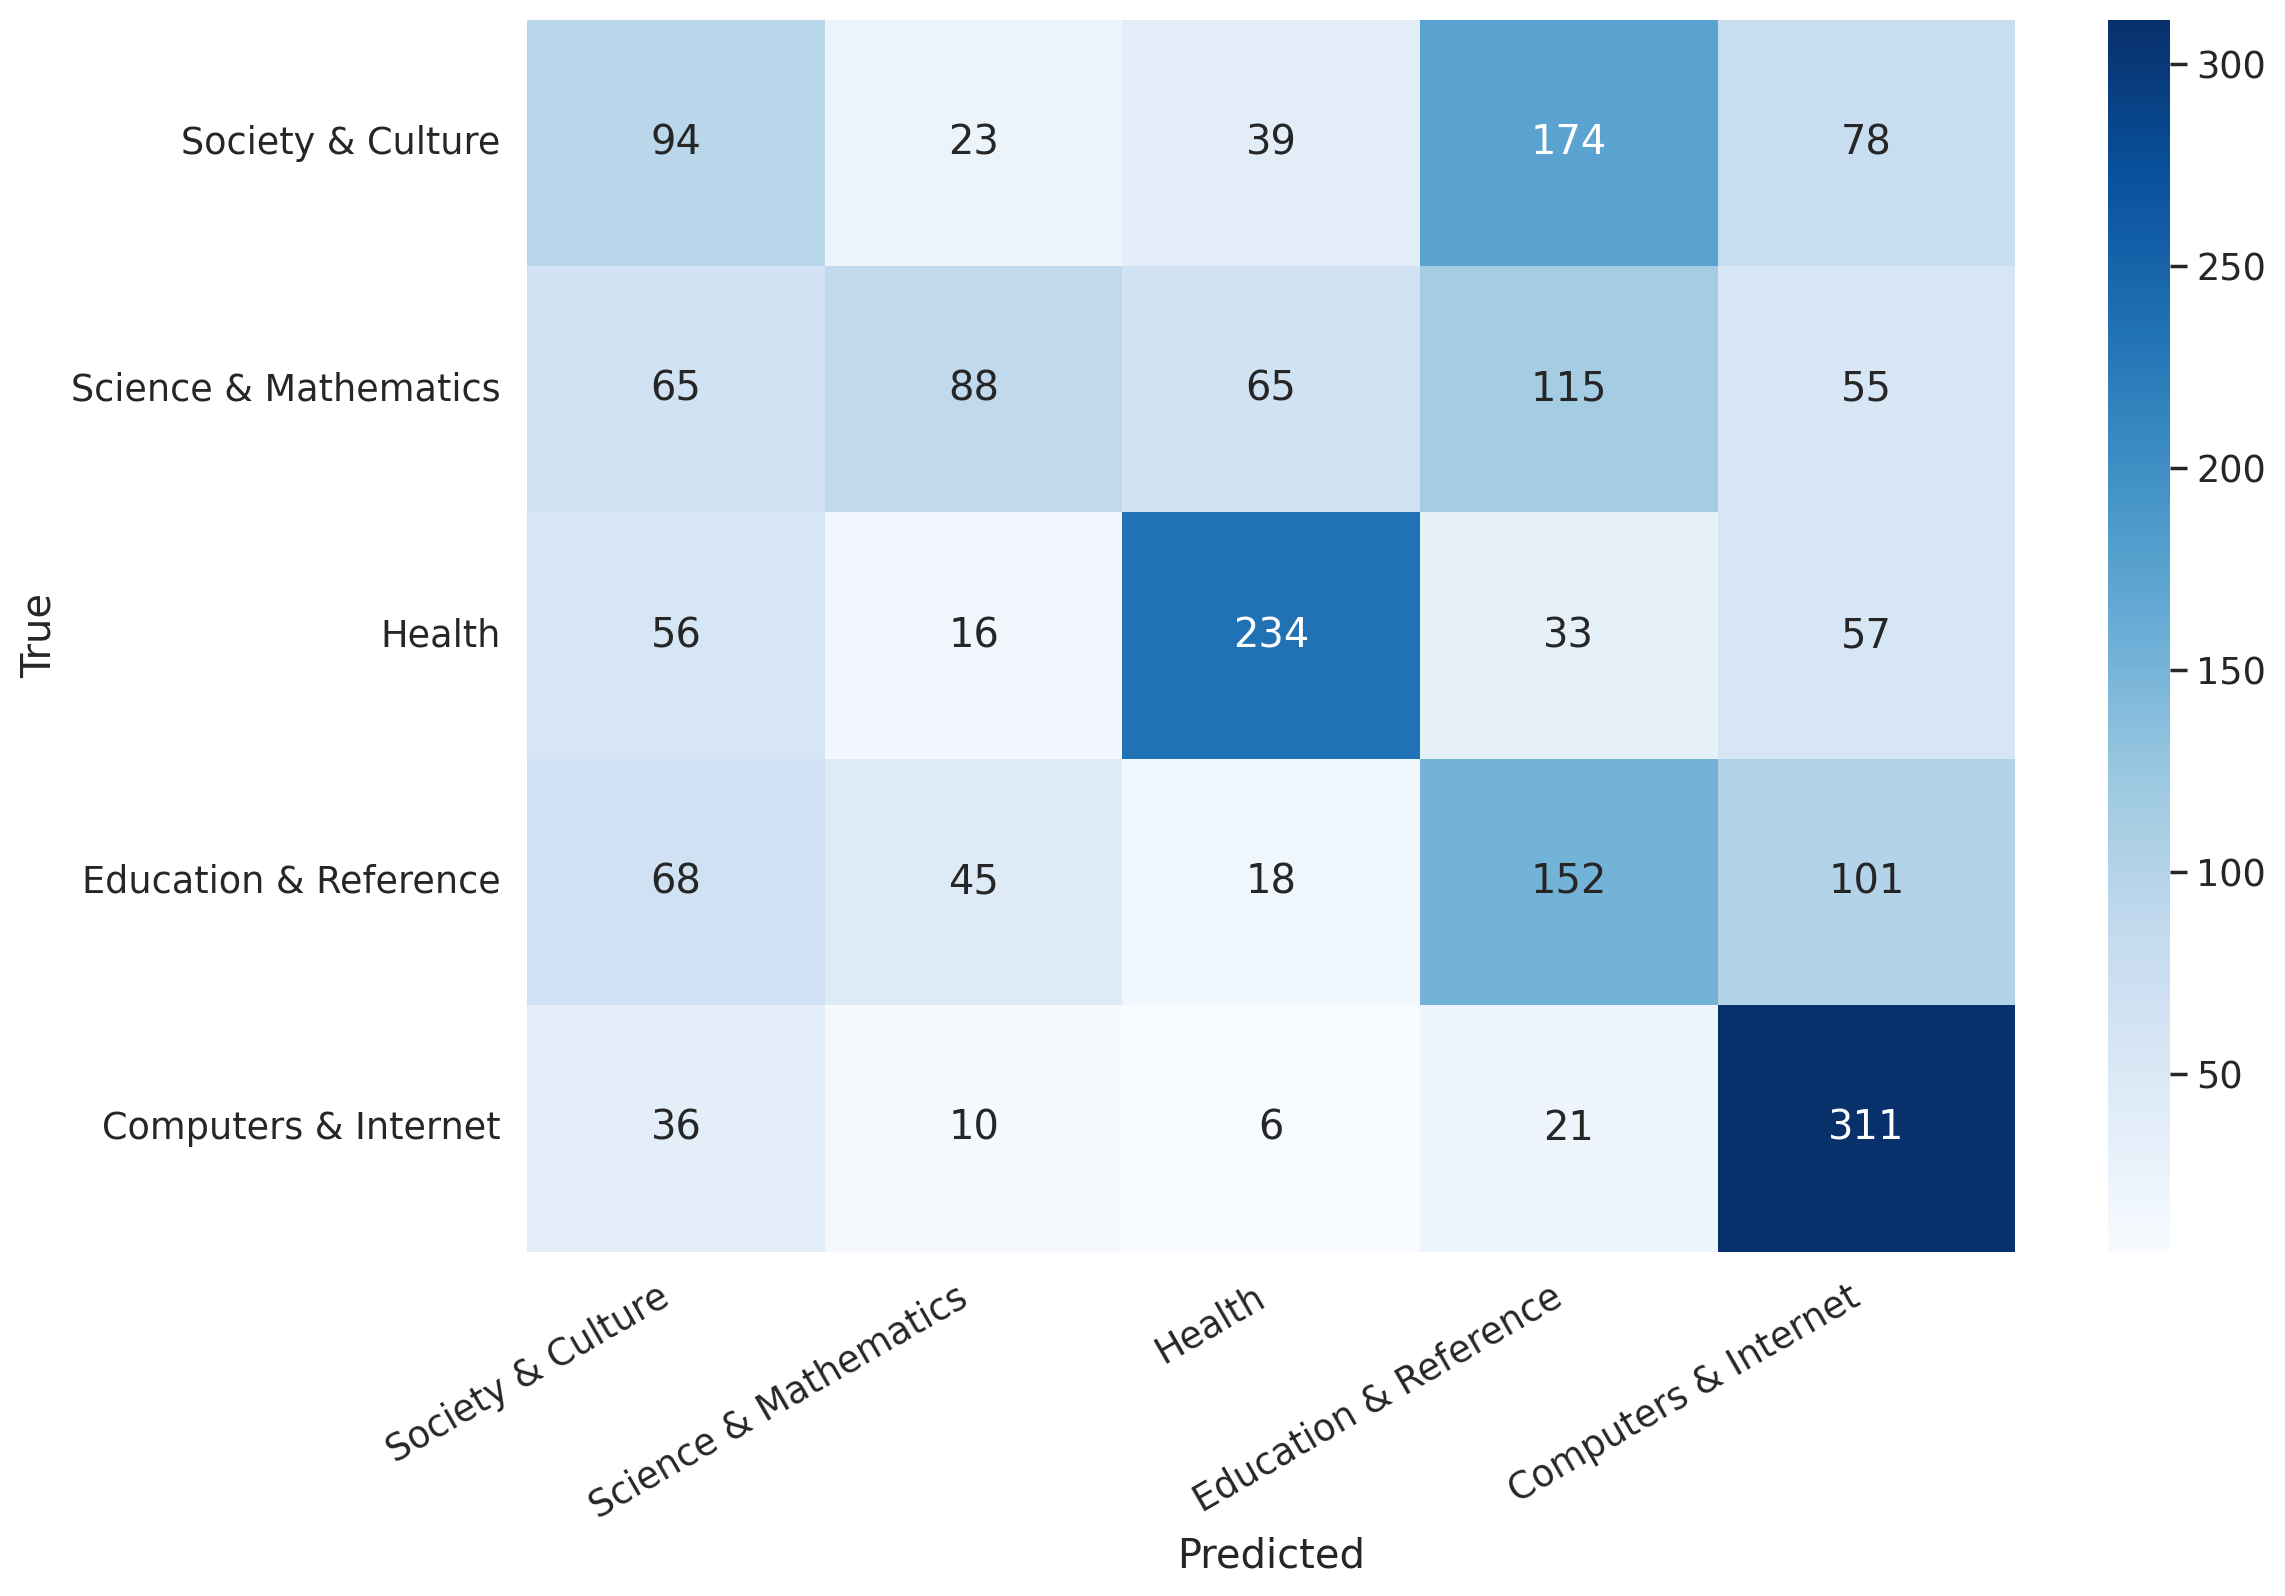

In [46]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels[0:5], columns=labels[0:5])
show_confusion_matrix(df_cm)

In [47]:
print(classification_report(y_test, y_pred, target_names=labels[0:5]))

                       precision    recall  f1-score   support

    Society & Culture       0.29      0.23      0.26       408
Science & Mathematics       0.48      0.23      0.31       388
               Health       0.65      0.59      0.62       396
Education & Reference       0.31      0.40      0.35       384
 Computers & Internet       0.52      0.81      0.63       384

             accuracy                           0.45      1960
            macro avg       0.45      0.45      0.43      1960
         weighted avg       0.45      0.45      0.43      1960

